In [1]:
!pip install pmdarima -qq

     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 17.5 MB/s 


In [2]:
import datetime
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import product
from tqdm import tqdm_notebook
from tqdm import tqdm
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf
import pmdarima as pm

from pylab import rcParams

from sklearn.metrics import mean_squared_error
import seaborn as sns

%matplotlib inline

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Apresentação dos dados

In [4]:
recifemensal = pd.read_excel("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/BASEFORTALEZAhorario.xlsx", index_col=0, parse_dates=[["Data", "HORA (UTC)"]])#.drop(columns=["Unnamed: 0"])

In [5]:
recifemensal

,Precipitacao,Temperatura,Velocidade,Pressao
Data_HORA (UTC),,,,
2014-10-01 00:00:00,0.0,26.4,3.0,1011.8
2014-10-01 01:00:00,0.0,26.3,2.9,1012.0
2014-10-01 02:00:00,0.0,26.3,3.4,1011.5
2014-10-01 03:00:00,0.0,26.4,3.0,1010.9
2014-10-01 04:00:00,0.0,26.1,2.0,1010.1
...,...,...,...,...
2014-10-31 19:00:00,0.0,29.5,4.4,1007.9
2014-10-31 20:00:00,0.0,27.8,3.9,1008.2
2014-10-31 21:00:00,0.0,26.7,3.1,1008.7


In [6]:
rcParams['figure.figsize'] = 30, 7

In [7]:
a = recifemensal['Velocidade'].values
b = recifemensal['Temperatura'].values
c = recifemensal['Pressao'].values
d = recifemensal['Precipitacao'].values

norm = np.linalg.norm(a)
x = a/norm

norm = np.linalg.norm(b)
y = b/norm

norm = np.linalg.norm(c)
z = b/norm

norm = np.linalg.norm(d)
v = b/norm

In [27]:
xc = ccf(a, d, adjusted=False)

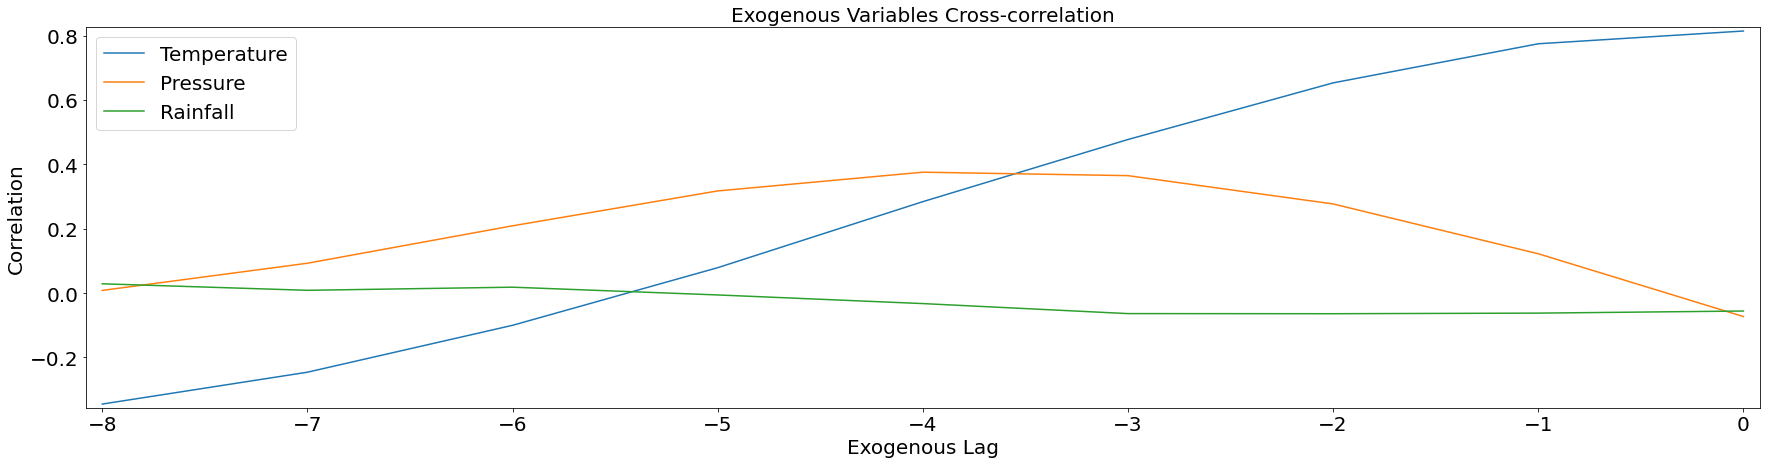

In [40]:
a = recifemensal['Velocidade'].values
b = recifemensal['Temperatura'].values
c = recifemensal['Pressao'].values
d = recifemensal['Precipitacao'].values

size=9
plt.plot(list(range(-size+1, 1)),ccf(a, b, adjusted=False)[:size][::-1], label='Temperature')
plt.plot(list(range(-size+1, 1)),ccf(a, c, adjusted=False)[:size][::-1], label='Pressure')
plt.plot(list(range(-size+1, 1)),ccf(a, d, adjusted=False)[:size][::-1], label='Rainfall')

plt.title("Exogenous Variables Cross-correlation", fontdict = {'fontsize' : 20})
plt.legend(fontsize=20, loc='upper left')
plt.ylabel('Correlation', fontdict = {'fontsize' : 20})
plt.xlabel('Exogenous Lag', fontdict = {'fontsize' : 20})
plt.tick_params(axis='both', which='major', labelsize=20)
plt.margins(x=0.01, y=0.01)

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.93893097, 0.94099607, 0.94296094, 0.94463057, 0.94632524,
        0.94803387, 0.94949832, 0.95082821, 0.95192529, 0.95288216,
        0.95409362, 0.95315213, 0.95222825, 0.95110607, 0.95008829,
        0.94938303, 0.94821225, 0.94710604, 0.94621748, 0.94545608,
        0.9449211 ]),
 <matplotlib.lines.Line2D at 0x7f111432cb50>)

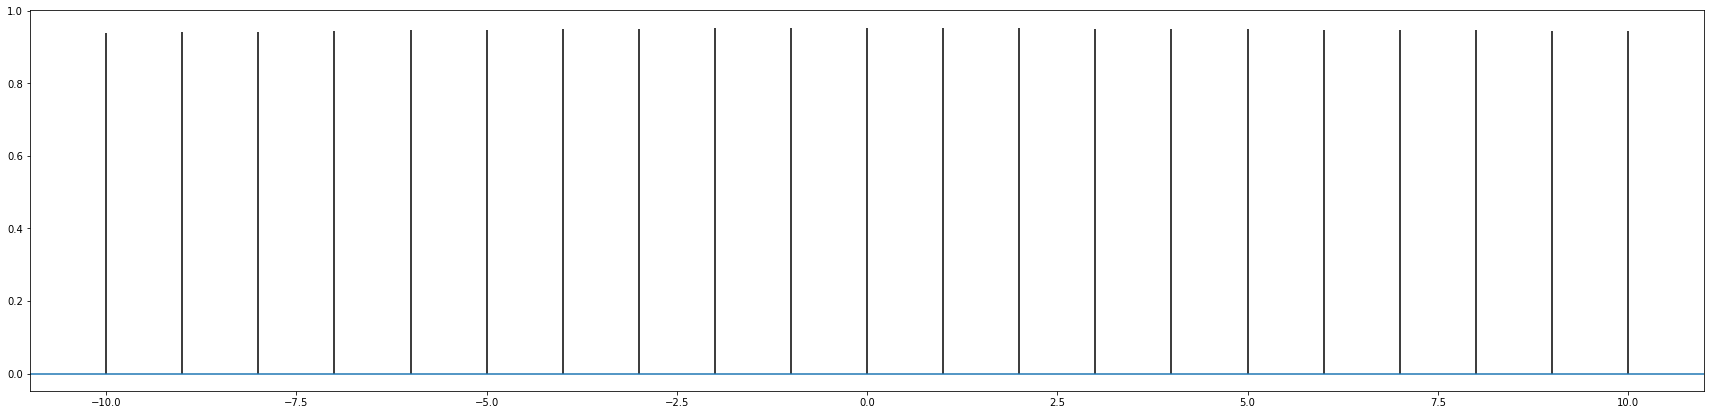

In [26]:
plt.xcorr(recifemensal['Velocidade'].values, recifemensal['Pressao'].values, usevlines=True, maxlags=10)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


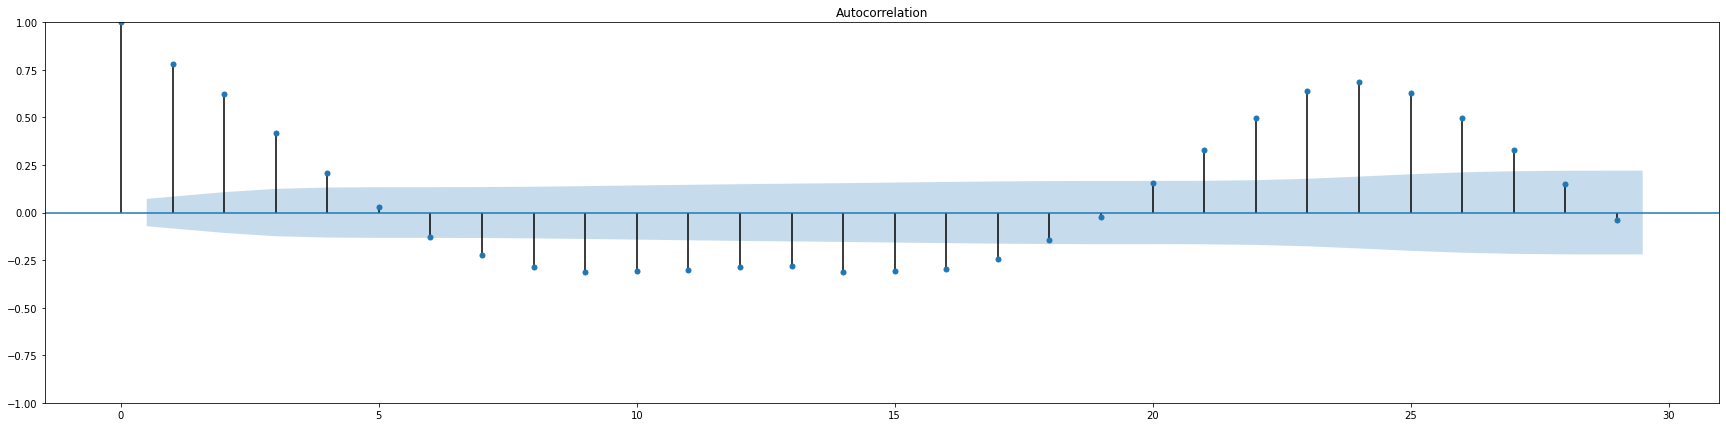

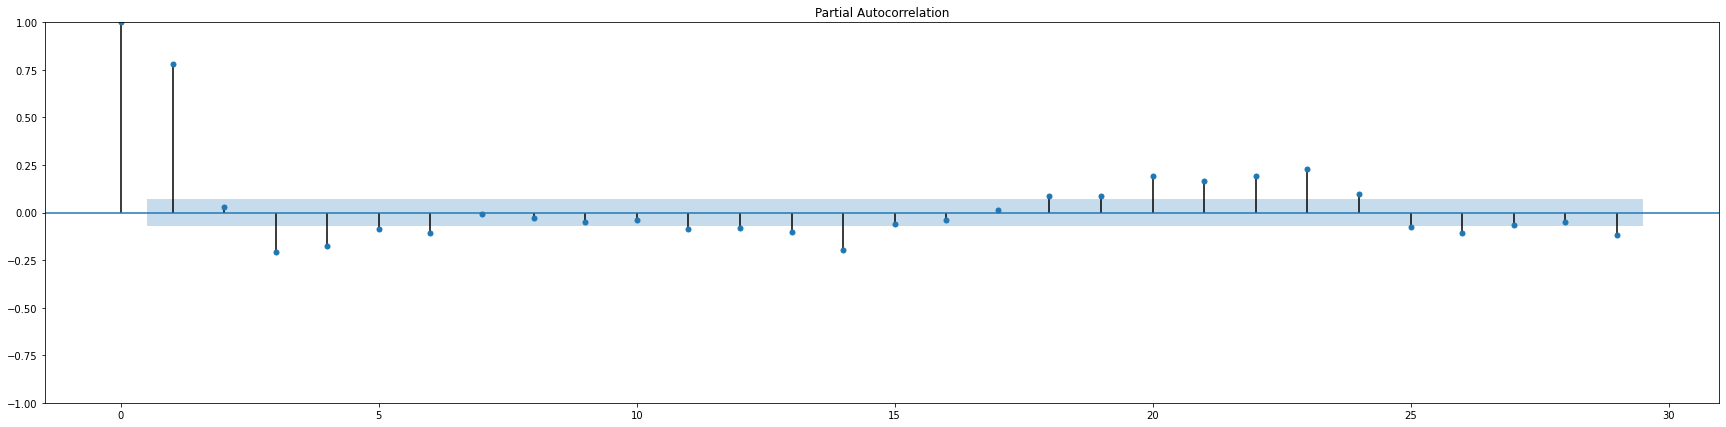

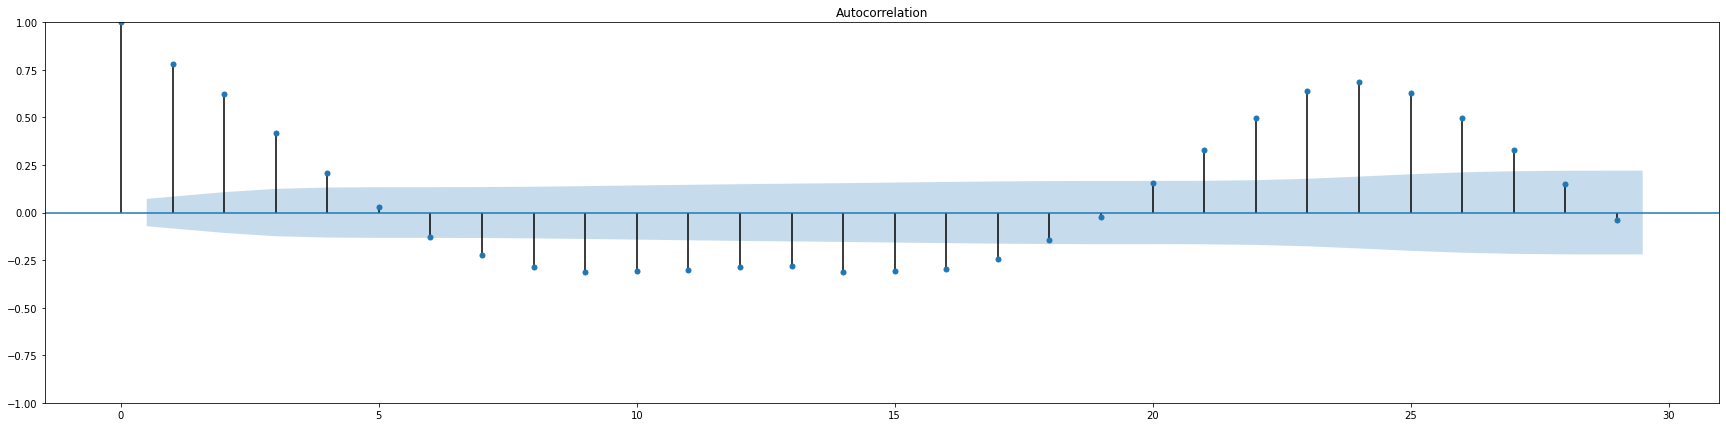

In [ ]:
plot_pacf(recifemensal["Velocidade"])
plot_acf(recifemensal["Velocidade"])

In [ ]:
quarto = int(recifemensal["Velocidade"].shape[0]/4)

In [ ]:
train = recifemensal["Velocidade"].iloc[:quarto*3].values.tolist()
test = recifemensal["Velocidade"].iloc[quarto*3:].values.tolist()

In [ ]:
model = pm.auto_arima(recifemensal["Velocidade"], D=1, m=24,trace=True,
                       error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[24] intercept   : AIC=inf, Time=38.62 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=1912.083, Time=0.47 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1527.272, Time=5.39 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=18.38 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=1910.475, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=1755.138, Time=0.49 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=1472.568, Time=12.69 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=56.95 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=17.16 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=1646.463, Time=10.58 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=1441.271, Time=13.48 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=1495.345, Time=5.80 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=57.26 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=25.71 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   : A

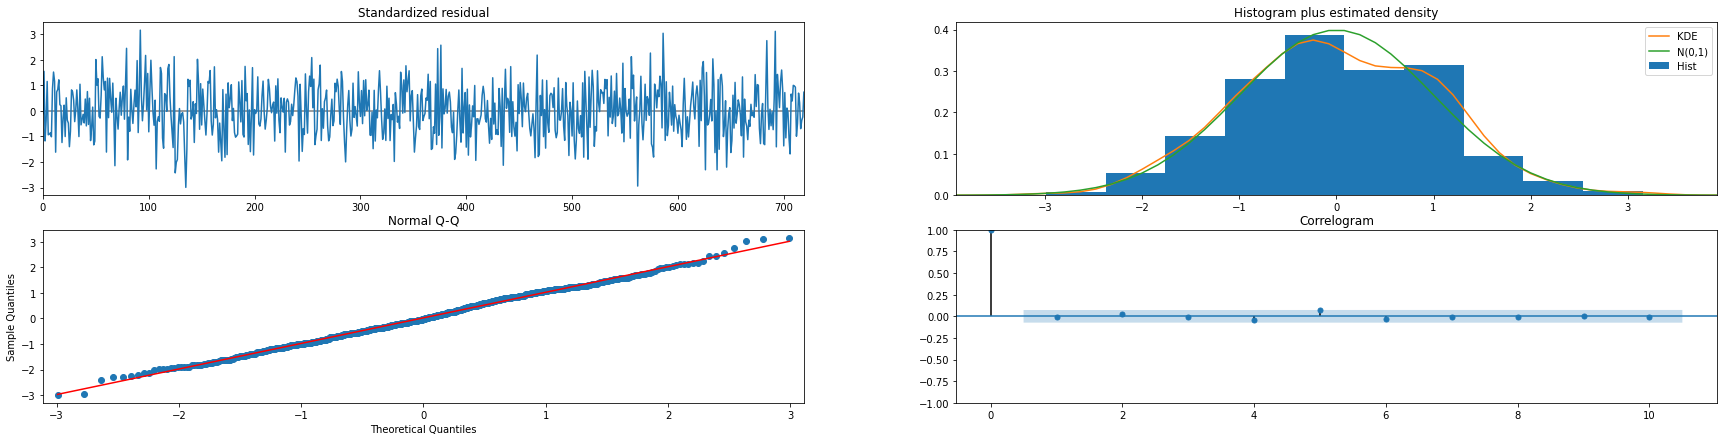

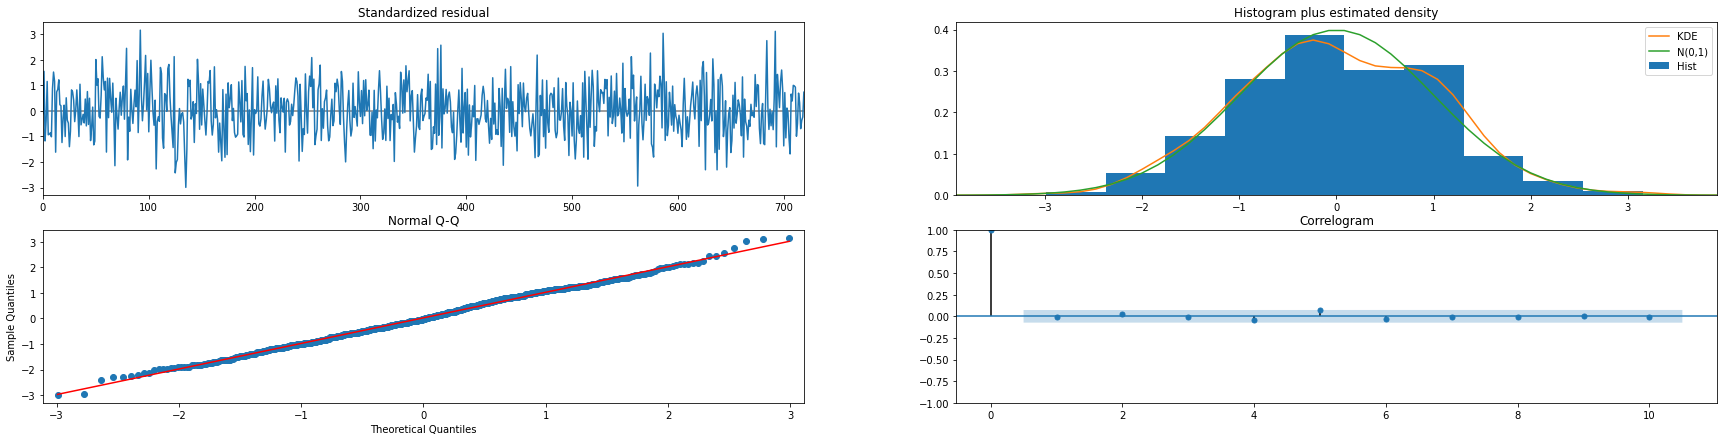

In [ ]:
model.plot_diagnostics()

#ARIMA(3,0,1)(0,0,0)[0]             : AIC=1722.390, Time=0.26 sec
#ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1722.430, Time=0.09 sec
#ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=1468.475, Time=27.19 sec
#ARIMA(1,0,1)(2,1,0)[24]             : AIC=1436.629, Time=6.01 sec
#ARIMA(4,1,1)(2,0,0)[24] intercept   : AIC=1480.557, Time=46.50 sec
#ARIMA(4,1,0)(2,1,0)[24] intercept   : AIC=1496.357, Time=20.06 sec


#ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1836.592, Time=2.73 sec
#ARIMA(5,0,1)(2,1,1)[12] intercept   : AIC=1843.583, Time=37.67 sec
#ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC=1812.349, Time=15.01 sec
#ARIMA(3,1,0)(2,1,0)[24]             : AIC=1858.038, Time=4.70 sec

In [ ]:
model.summary()
#(5, 1, 3)x(2, 0, 0, 12)
#61851.170

#SARIMAX(5, 1, 1)x(1, 0, [], 12) 	
#62170.854

#SARIMAX(5, 0, 0)x(2, 1, [1], 12)
#62373.948

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  744
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 24)   Log Likelihood                -713.315
Date:                             Mon, 27 Jun 2022   AIC                           1436.629
Time:                                     06:53:32   BIC                           1459.526
Sample:                                          0   HQIC                          1445.469
                                             - 744                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7911      0.040     19.681      0.000       0.712       0.870
ma.L1         -0.4320      0.061     -7.103      0.000      -0.551      -0.313
ar.S.L24      -0.6687      0.037    -18.134      0.000      -0.741      -0.596
ar.S.L48      -0.2808      0.038     -7.445      0.000      -0.355      -0.207
sigma2         0.4177      0.024     17.521      0.000       0.371       0.464
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.83   Prob(JB):                         0.51
Heteroskedasticity (H):               1.00   Skew:                             0.04
Prob(H) (two-sided):                  1.00   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = pm.arima.ARIMA(model.get_params()['order'], model.get_params()['seasonal_order'],
                       error_action='ignore', suppress_warnings=True)
model.fit(recifemensal["Velocidade"])

ARIMA(order=(1, 0, 1), seasonal_order=(2, 1, 0, 24), suppress_warnings=True)

In [ ]:
pd.Series(model.resid()).to_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/fortalezahora_resid_series.csv")

In [ ]:
model = pm.arima.ARIMA(model.get_params()['order'], model.get_params()['seasonal_order'],
                       error_action='ignore', suppress_warnings=True)
model.fit(train)

prediction = model.predict(len(test))

pd.Series(prediction).to_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/fortalezahora_prediction_bad.csv")
test_resid = [a_i - b_i for a_i, b_i in zip(test, prediction)]
pd.Series(test_resid).to_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/fortalezahora_resid_test_bad.csv")

In [ ]:
from tqdm import tqdm

prediction = []
history = train.copy()
for i in tqdm(range(len(test))):
    model = pm.arima.ARIMA(model.get_params()['order'], model.get_params()['seasonal_order'],
                       error_action='ignore', suppress_warnings=True)
    model.fit(history)
    #print(f'working on {i+1}')
    prediction.append(model.predict()[0])
    history.append(test[i])

test_resid = [a_i - b_i for a_i, b_i in zip(test, prediction)]
pd.Series(test_resid).to_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/fortalezahora_resid_test_good.csv")
pd.Series(prediction).to_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/fortalezahora_prediction_good.csv")

100%|██████████| 186/186 [56:42<00:00, 18.29s/it]


In [ ]:
prediction = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/fortalezahora_prediction_good.csv")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

In [ ]:
prediction = prediction["0"].values

In [ ]:
print(mean_squared_error(prediction, test))
print(sqrt(mean_squared_error(prediction, test)))
print(mean_absolute_error(prediction, test))
print(mean_absolute_percentage_error(prediction, test))

0.5511887225068913
0.7424208526886158
0.602719350709127
0.1935772539956629
